SIMO FODJO WELL YOHAN NATHAN

DECISION TREE

1. Importation des bibliothèques et chargement des données

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Chargement des données
data = pd.read_csv('./csv/heartdisease.csv')

2. Exploration des données

In [3]:
# Aperçu des données
data.head(5)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [4]:
#Suppression des doublons
print(data.duplicated().value_counts())
data = data.drop_duplicates()

False    918
True     272
Name: count, dtype: int64


In [5]:
# Dimensions du dataset
print(f"Shape: {data.shape}")

Shape: (918, 12)


In [6]:
#Les informations sur les donnees
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  918 non-null    int64  
 1   sex                  918 non-null    int64  
 2   chest pain type      918 non-null    int64  
 3   resting bp s         918 non-null    int64  
 4   cholesterol          918 non-null    int64  
 5   fasting blood sugar  918 non-null    int64  
 6   resting ecg          918 non-null    int64  
 7   max heart rate       918 non-null    int64  
 8   exercise angina      918 non-null    int64  
 9   oldpeak              918 non-null    float64
 10  ST slope             918 non-null    int64  
 11  target               918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 93.2 KB


In [7]:
#Description des donnees
data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.789760,3.251634,132.396514,198.799564,0.233115,0.603486,136.809368,0.404139,0.887364,1.636166,0.553377
std,9.432617,0.407701,0.931031,18.514154,109.384145,0.423046,0.805968,25.460334,0.490992,1.066570,0.609341,0.497414
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,173.250000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [8]:
# Vérification des valeurs manquantes
data.isnull().sum()

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

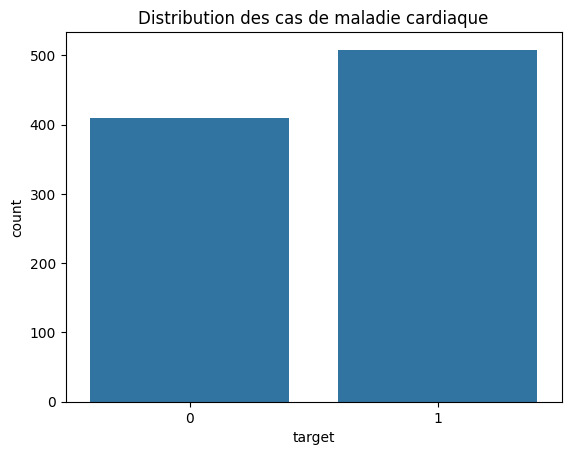

In [9]:
# Distribution de la variable cible
sns.countplot(x='target', data=data)
plt.title('Distribution des cas de maladie cardiaque')
plt.show()

3. Analyse visuelle des données

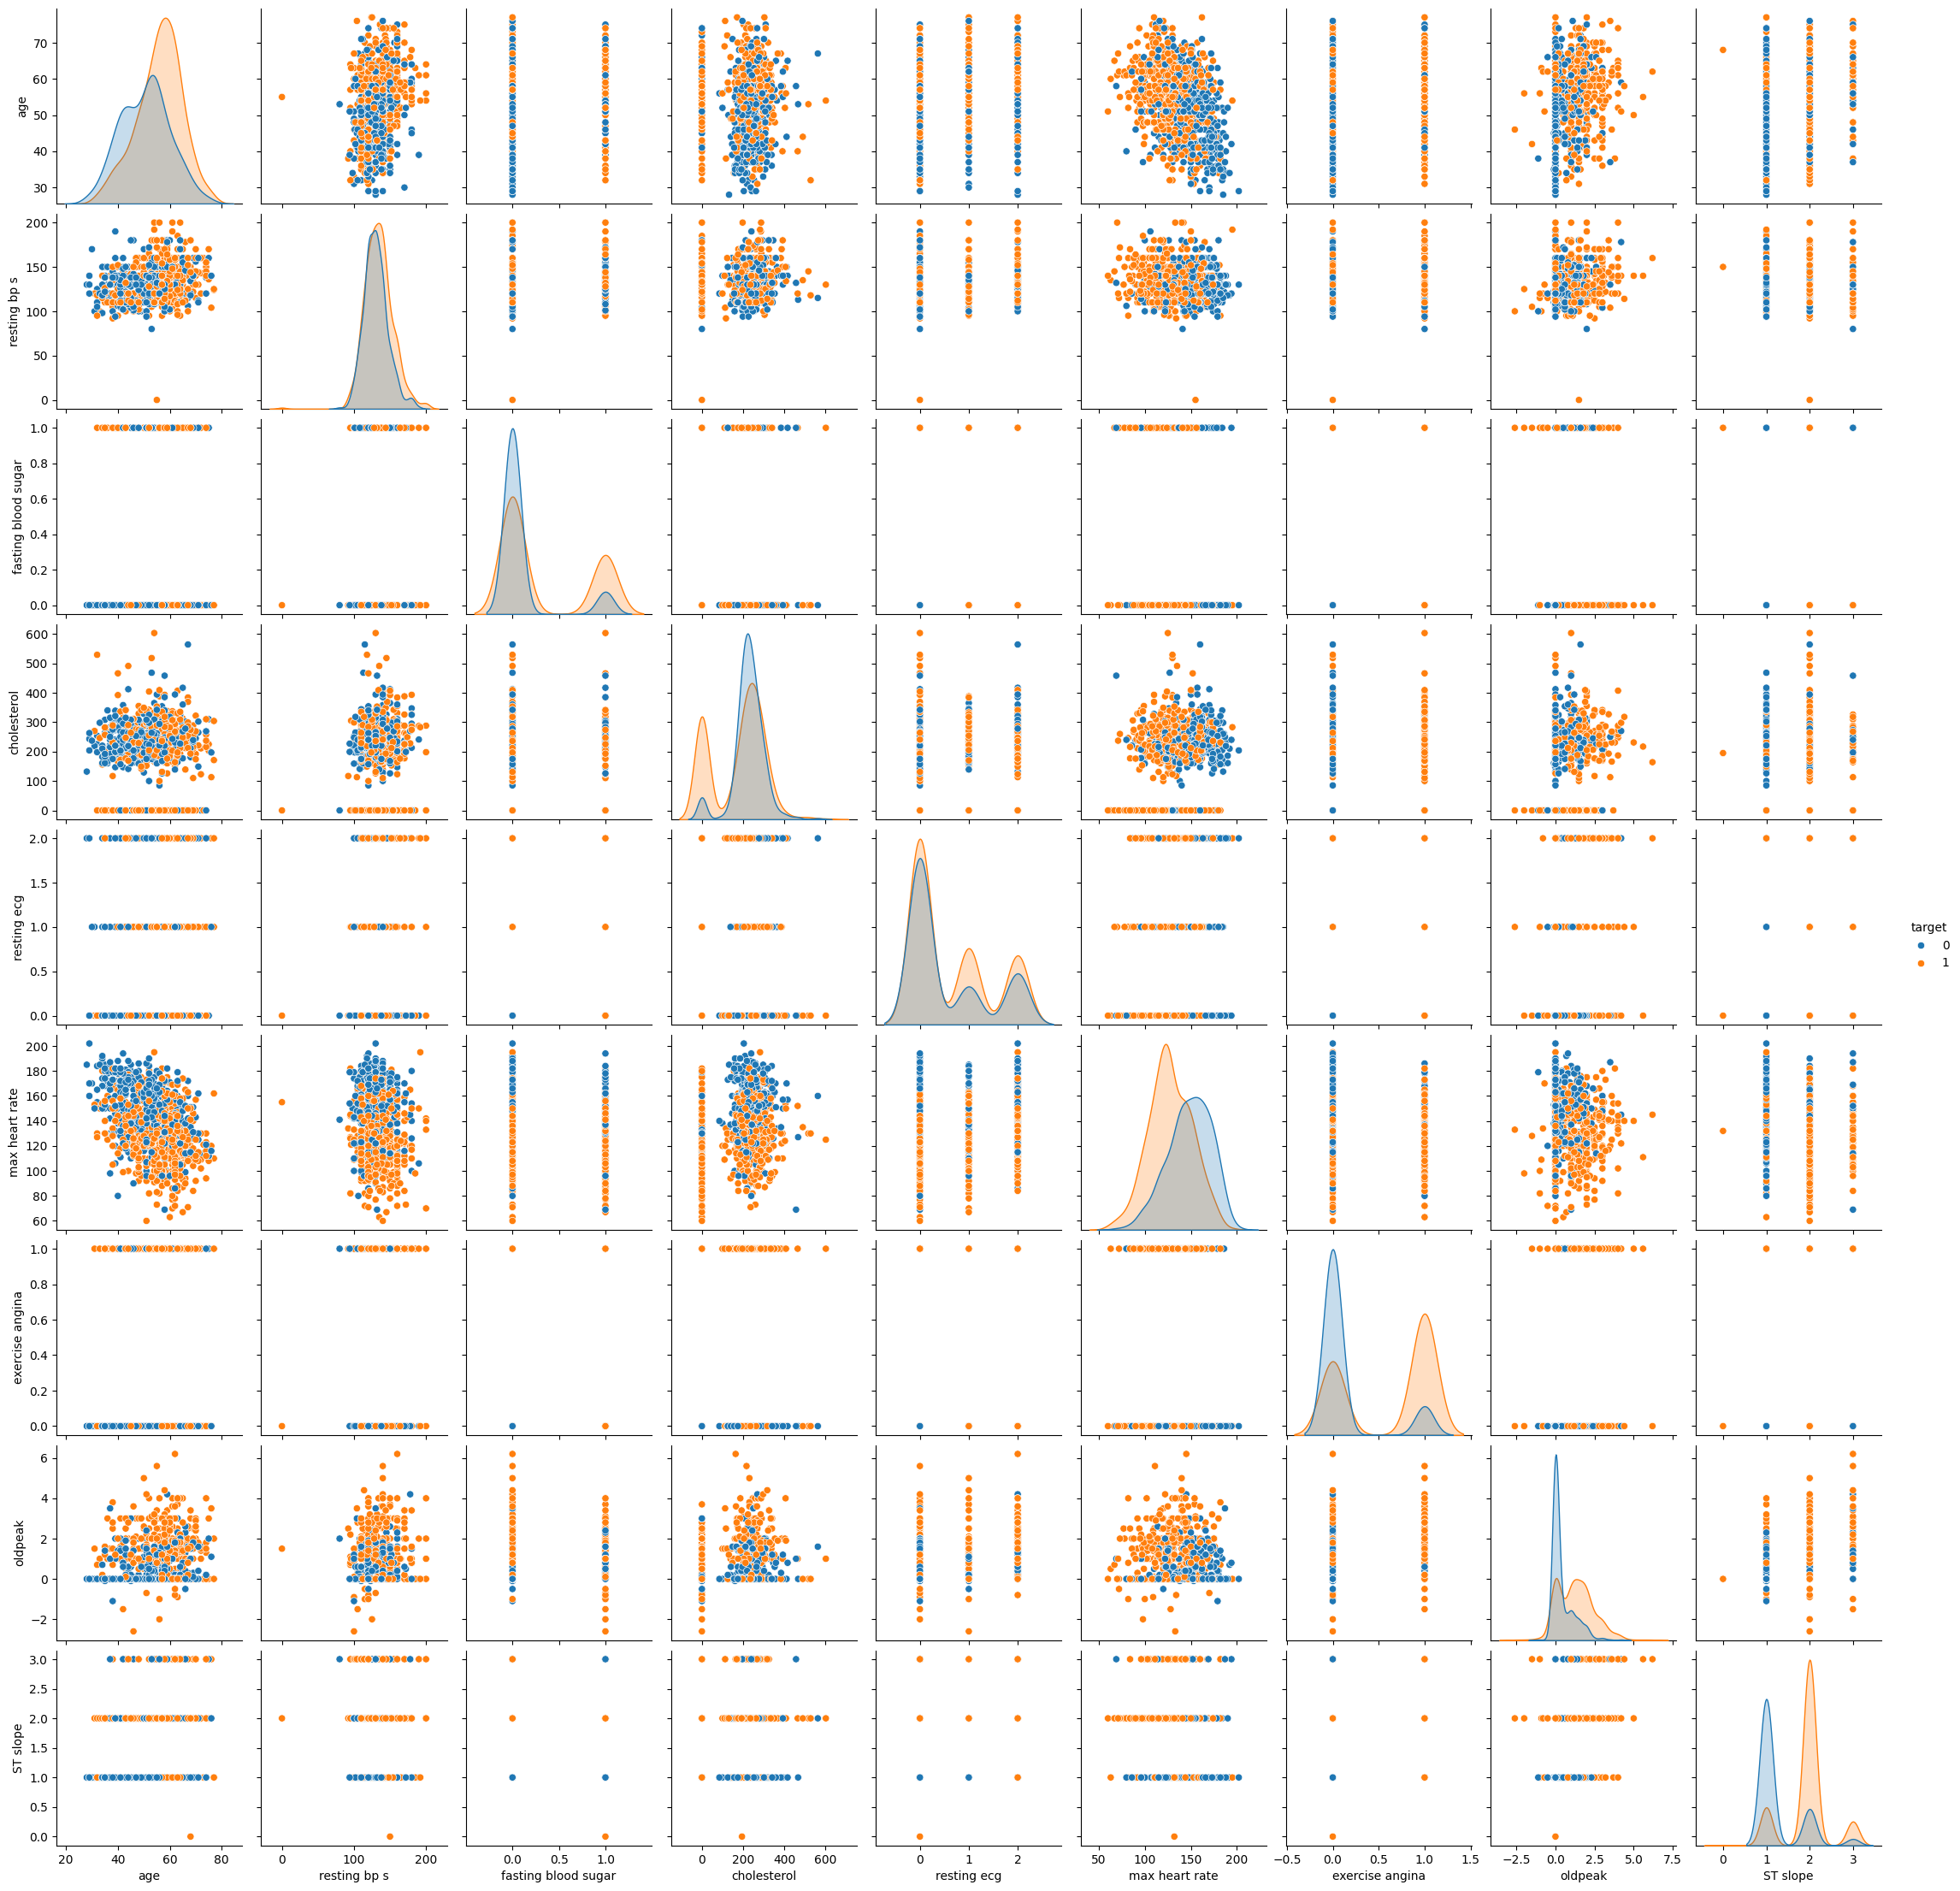

In [10]:
# Pairplot pour voir les relations entre variables
sns.pairplot(data, hue='target', vars=['age', 'resting bp s', 'fasting blood sugar', 'cholesterol', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope'])
plt.show()

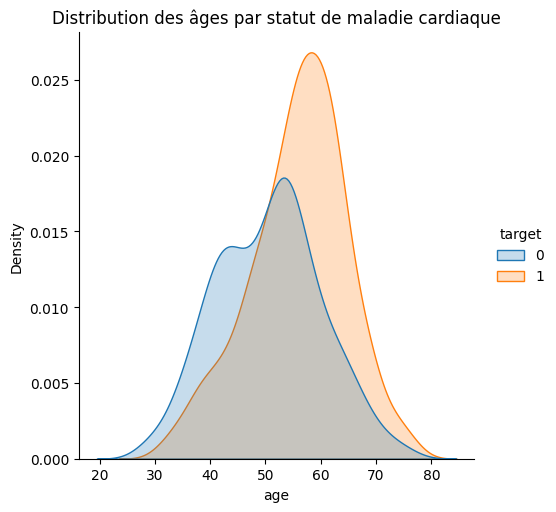

In [11]:
# Distribution des âges
sns.displot(data, x='age', hue='target', kind='kde', fill=True)
plt.title('Distribution des âges par statut de maladie cardiaque')
plt.show()

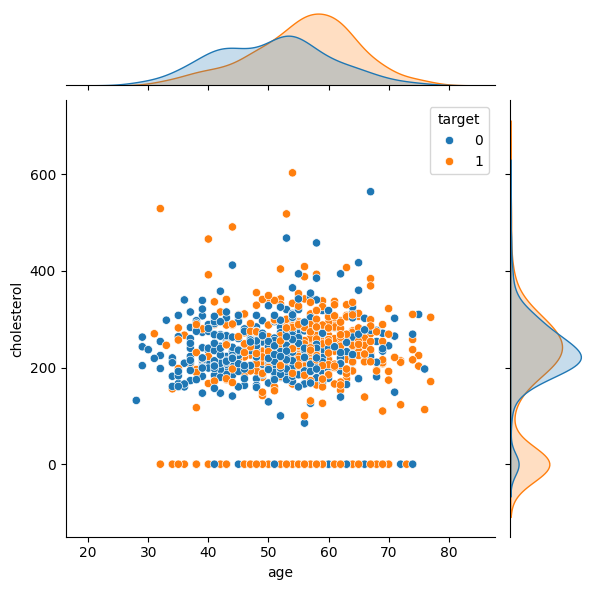

In [12]:
# Distribution des âges en fonction du taux de cholesterol
sns.jointplot(x='age', y='cholesterol', data=data, hue='target', color='blue')

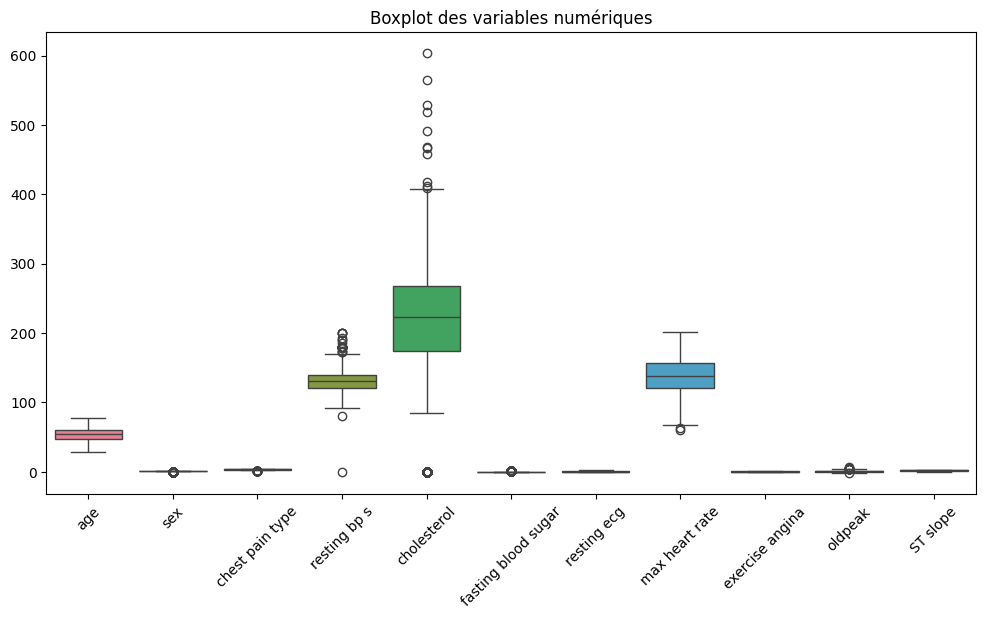

In [13]:
# Boxplot des variables numériques
def showBoxplot() :
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data.drop('target', axis=1))
    plt.title('Boxplot des variables numériques')
    plt.xticks(rotation=45)
    plt.show()

showBoxplot()

In [14]:
num_col = ['resting bp s', 'cholesterol', 'max heart rate', 'oldpeak', 'fasting blood sugar']
def replace_quantile(data):
    for colonne in num_col:
        q1 = data[colonne].quantile(0.25)
        q3 = data[colonne].quantile(0.75)
        iqr = q3 - q1
        borne_inf = q1 - 1.5 * iqr
        borne_sup = q3 + 1.5 * iqr
        data[colonne] = np.where(data[colonne] < borne_inf, borne_inf, data[colonne])
        data[colonne] = np.where(data[colonne] > borne_sup, borne_sup, data[colonne])


#borner les valeur aberrante
replace_quantile(data) 


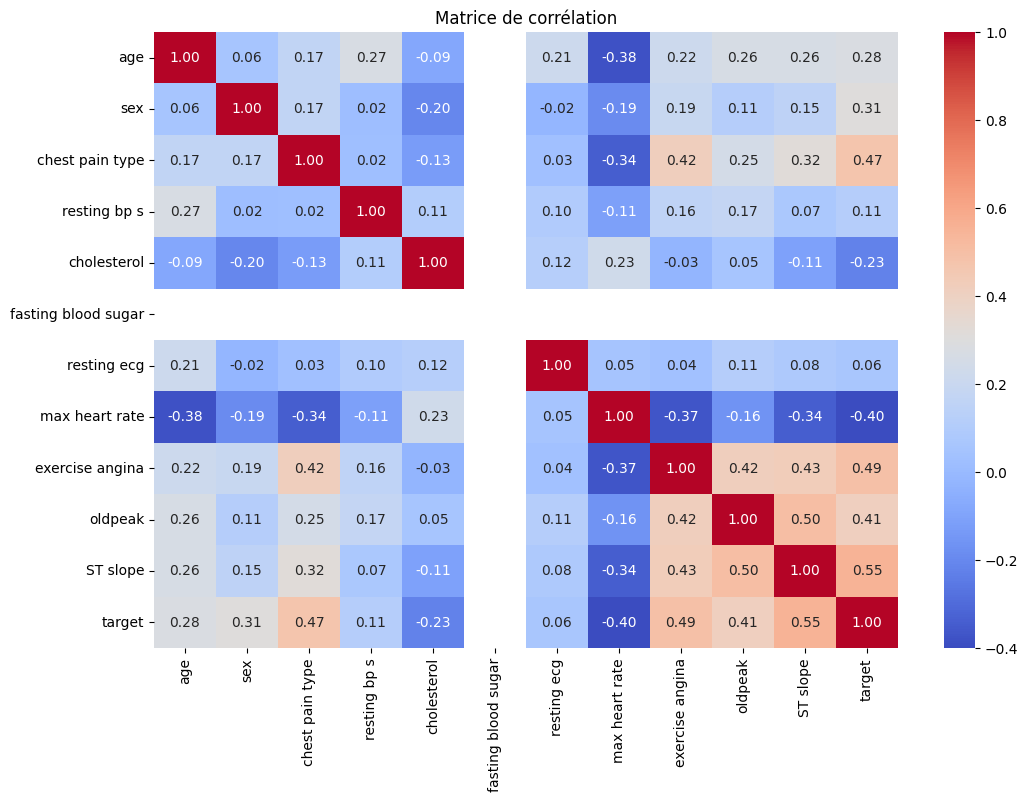

In [15]:
# Heatmap de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.show()

4. Préparation des données

In [16]:
# Séparation des features et de la cible
X = data.drop('target', axis=1)
y = data['target']

In [17]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

5. Modélisation avec Decision Tree

In [18]:
# Création et entraînement du modèle
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [19]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Score d'entrainnement: {train_score}\nScore de teste :{test_score}")

Score d'entrainnement: 0.8950953678474114
Score de teste :0.8206521739130435


In [20]:
#Préprocessing 
num_features = ['resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
cat_features = ['age', 'sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']

# Construction du préprocesseur
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

In [21]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [22]:
# Entraînement du modèle
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['resting bp s',
                                                   'cholesterol',
                                                   'max heart rate',
                                                   'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age', 'sex',
                                                   'chest pain type',
                                                   'fasting blood sugar',
                                                   'resting ecg',
                                                   'exercise angina',
                                                   'ST slope'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [23]:

# Évaluation sur l'ensemble de test
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

In [24]:
# Scores
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Score sur l'ensemble d'entraînement: {train_score:.2f}")
print(f"Score sur l'ensemble de test: {test_score:.2f}")
print("\nRapport de classification:\n", classification_report(y_test, y_pred))

Score sur l'ensemble d'entraînement: 1.00
Score sur l'ensemble de test: 0.80

Rapport de classification:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78        82
           1       0.82      0.81      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



6. Validation croisée

In [25]:
# Validation croisée
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10)
print(f"Scores de validation croisée: {cv_scores}")
print(f"Moyenne des scores de validation croisée: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Scores de validation croisée: [0.83783784 0.86486486 0.72972973 0.7972973  0.84931507 0.80821918
 0.73972603 0.79452055 0.78082192 0.76712329]
Moyenne des scores de validation croisée: 0.80 ± 0.04


7. Courbe de validation

In [26]:
# Courbe de validation pour DecisionTreeClassifier
param_range = range(1, 21)  # Plage de valeurs pour max_depth
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42), X_train, y_train, 
    param_name="max_depth", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)

In [27]:
# Calcul des moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

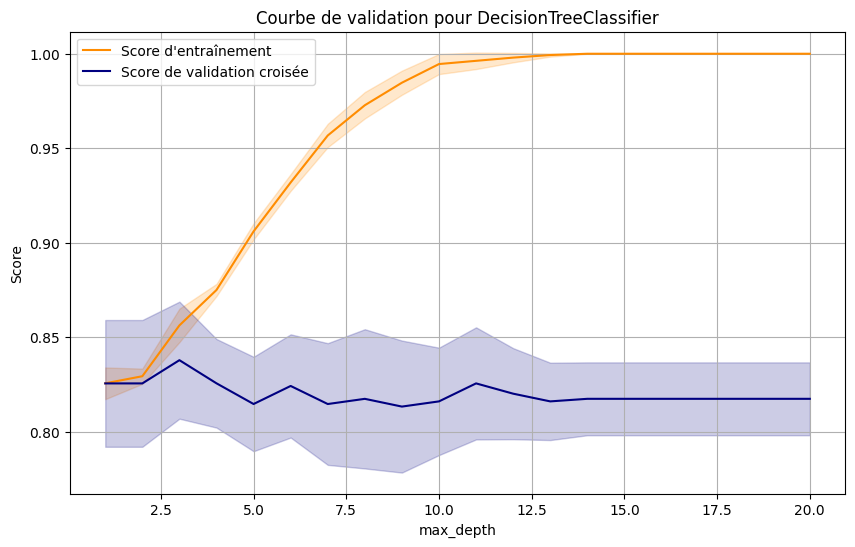

In [28]:
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Score d'entraînement", color="darkorange")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
plt.plot(param_range, test_mean, label="Score de validation croisée", color="navy")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="navy")
plt.title("Courbe de validation pour DecisionTreeClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()

8. Optimisation avec GridSearchCV

In [29]:
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score: {grid_search.best_score_:.2f}")

Meilleurs paramètres: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
Meilleur score: 0.85


In [30]:
# Evaluation sur le test set
y_pred = grid_search.predict(X_test)
print(f"\nAccuracy sur le test set: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy sur le test set: 0.821

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        82
           1       0.87      0.79      0.83       102

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.83      0.82      0.82       184



9. Matrice de confusion

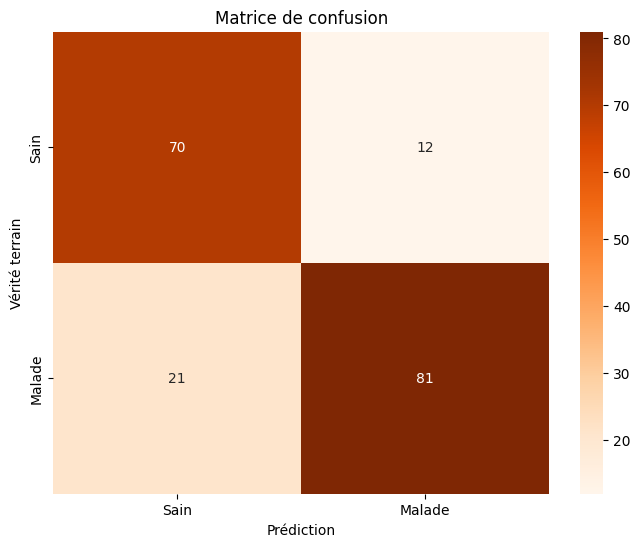

In [31]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Sain', 'Malade'], 
            yticklabels=['Sain', 'Malade'])
plt.title('Matrice de confusion')
plt.ylabel('Vérité terrain')
plt.xlabel('Prédiction')
plt.show()

10. Courbe ROC

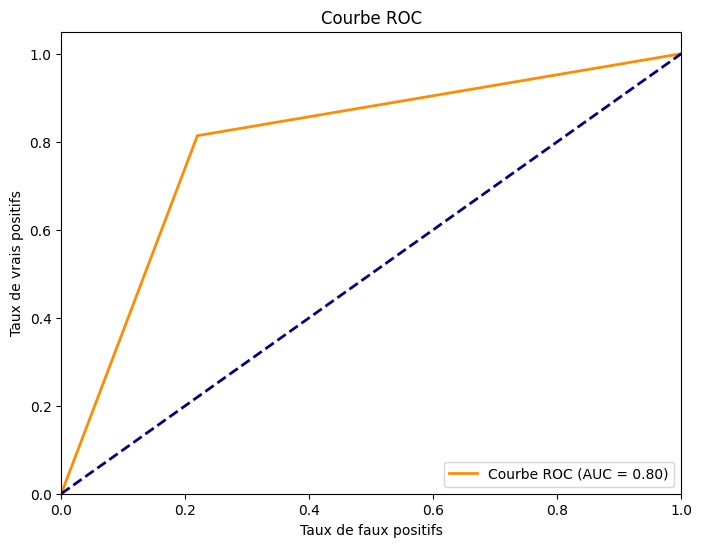

In [32]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

11. Courbe d'apprentissage

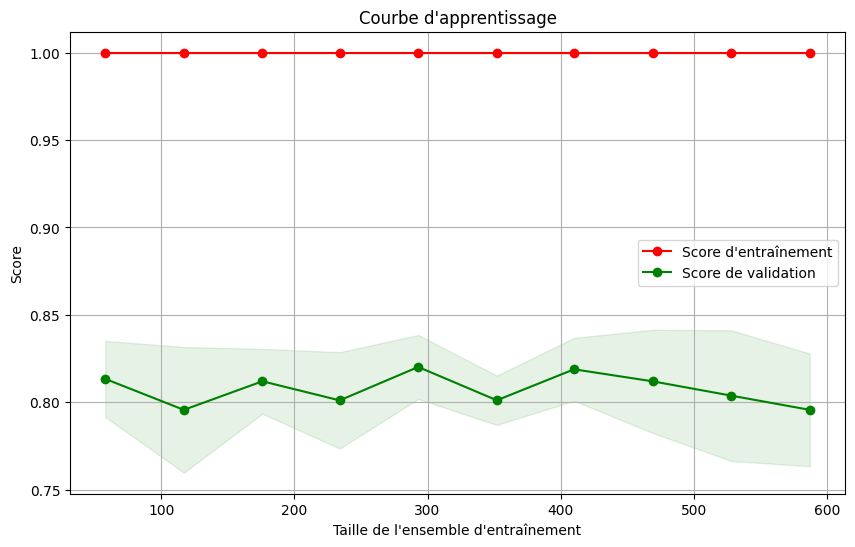

In [33]:
# Courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Score de validation")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.title("Courbe d'apprentissage")
plt.legend(loc="best")
plt.grid()
plt.show()

In [34]:
# Sauvegarde du meilleur modèle
best_model = grid_search.best_estimator_
joblib.dump(best_model, './params/joblib/heart_model_pipeline_decision_tree.joblib')
print("Modèle sauvegardé sous 'heart_model_pipeline_decision_tree.joblib'")

Modèle sauvegardé sous 'heart_model_pipeline_decision_tree.joblib'


In [35]:
# Sauvegarde des noms de colonnes pour Streamlit
feature_names = list(X.columns)
joblib.dump(feature_names, './params/joblib/feature_names_decision_tree.joblib')

['./params/joblib/feature_names_decision_tree.joblib']

In [36]:
data.to_csv("./csv/cleaned_dataset.csv", index=False)